In [1]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set global parameters
data_dir = '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer'
img_size = (224, 224)
batch_size = 64

# Load saved model
model = load_model('/kaggle/input/cancer_main_model_efficientnetb0/keras/v4.8/1/cancer_main_model_efficientnetB0.keras')

In [2]:
# Then continue with the test DataFrame creation
def create_test_df():
    target_folders = ['ALL','Brain Cancer','Breast Cancer','Cervical Cancer',
                    'Kidney Cancer','Lung and Colon Cancer','Lymphoma','Oral Cancer']
    
    filepath = []
    labels = []

    for target_folder in target_folders:
        all_folder_path = os.path.join(data_dir, target_folder)
        if not os.path.isdir(all_folder_path):
            continue

        filelist = os.listdir(all_folder_path)
        for f in filelist:
            fpath = os.path.join(all_folder_path, f)
            if not os.path.isdir(fpath):
                continue

            fipath = os.listdir(fpath)
            for image in fipath:
                if image.lower().endswith(('.png', '.jpg', '.jpeg')):
                    path = os.path.join(fpath, image)
                    filepath.append(path)
                    labels.append(f"{target_folder}/{f}")

    return pd.DataFrame({'filepath': filepath, 'labels': labels})

# Now the rest of the code will work
full_df = create_test_df()
strat = full_df['labels']
train_df, dummy_df = train_test_split(full_df, test_size=0.3, random_state=42, stratify=strat)
strate = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df, test_size=0.5, random_state=42, stratify=strate)

In [3]:
# Create test generator
test_gen = ImageDataGenerator().flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 19501 validated image filenames belonging to 26 classes.


In [4]:
# 1. Basic Evaluation
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f'\nTest Accuracy: {test_acc * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

# 2. Detailed Classification Report
test_gen.reset()
y_true = test_gen.classes
y_pred = model.predict(test_gen, verbose=1).argmax(axis=1)
class_names = list(test_gen.class_indices.keys())

print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


305/305 ━━━━━━━━━━━━━━━━━━━━ 233s 734ms/step - accuracy: 0.0889 - loss: 30.6077

Test Accuracy: 8.92%
Test Loss: 30.6002
305/305 ━━━━━━━━━━━━━━━━━━━━ 82s 253ms/step

Classification Report:
                                 precision    recall  f1-score   support

                 ALL/all_benign     0.9101    0.1080    0.1931       750
                  ALL/all_early     0.6167    0.0493    0.0914       750
                    ALL/all_pre     0.9875    0.1053    0.1904       750
                    ALL/all_pro     1.0000    0.4373    0.6085       750
      Brain Cancer/brain_glioma     0.0000    0.0000    0.0000       750
       Brain Cancer/brain_menin     0.0000    0.0000    0.0000       750
       Brain Cancer/brain_tumor     0.0000    0.0000    0.0000       750
    Breast Cancer/breast_benign     0.2838    0.0280    0.0510       750
 Breast Cancer/breast_malignant     0.8333    0.0067    0.0132       750
     Cervical Cancer/cervix_dyk     0.0413    0.0760    0.0535       750
     Ce

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


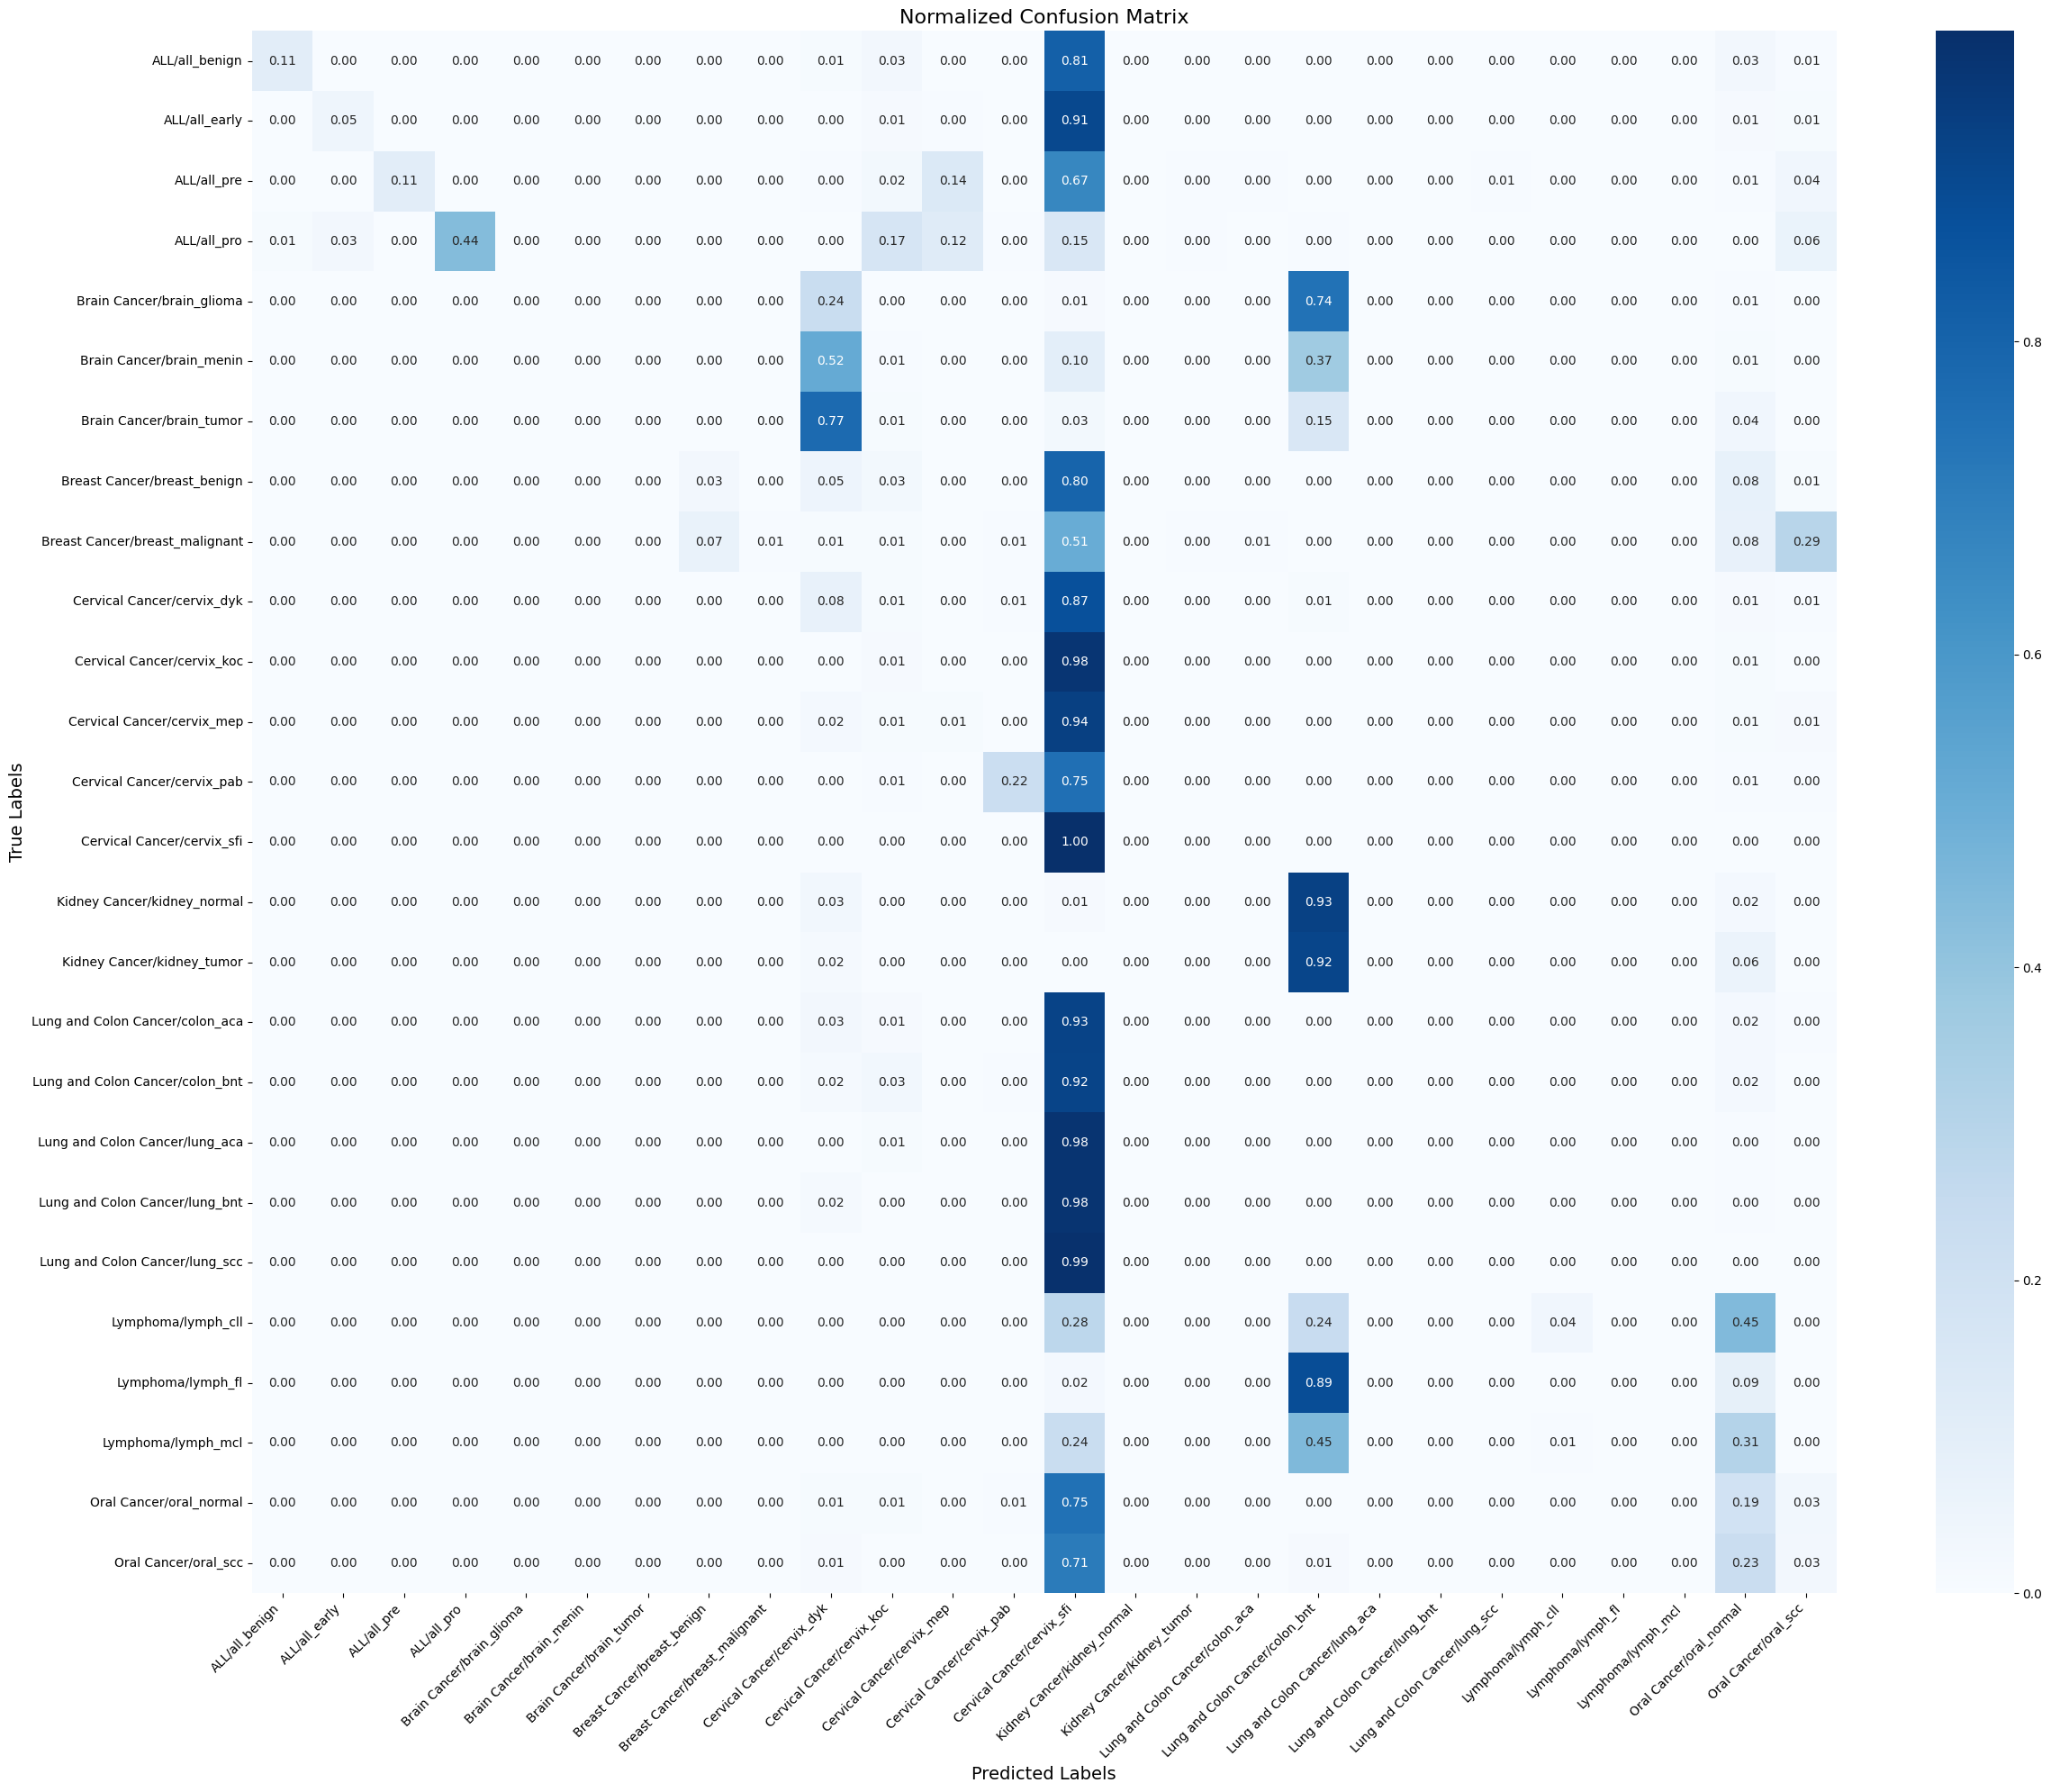

Training history not available in this notebook


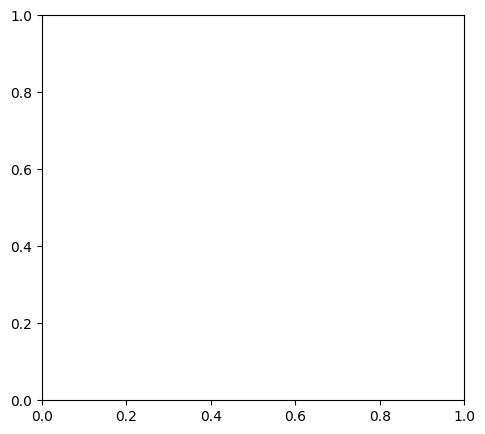

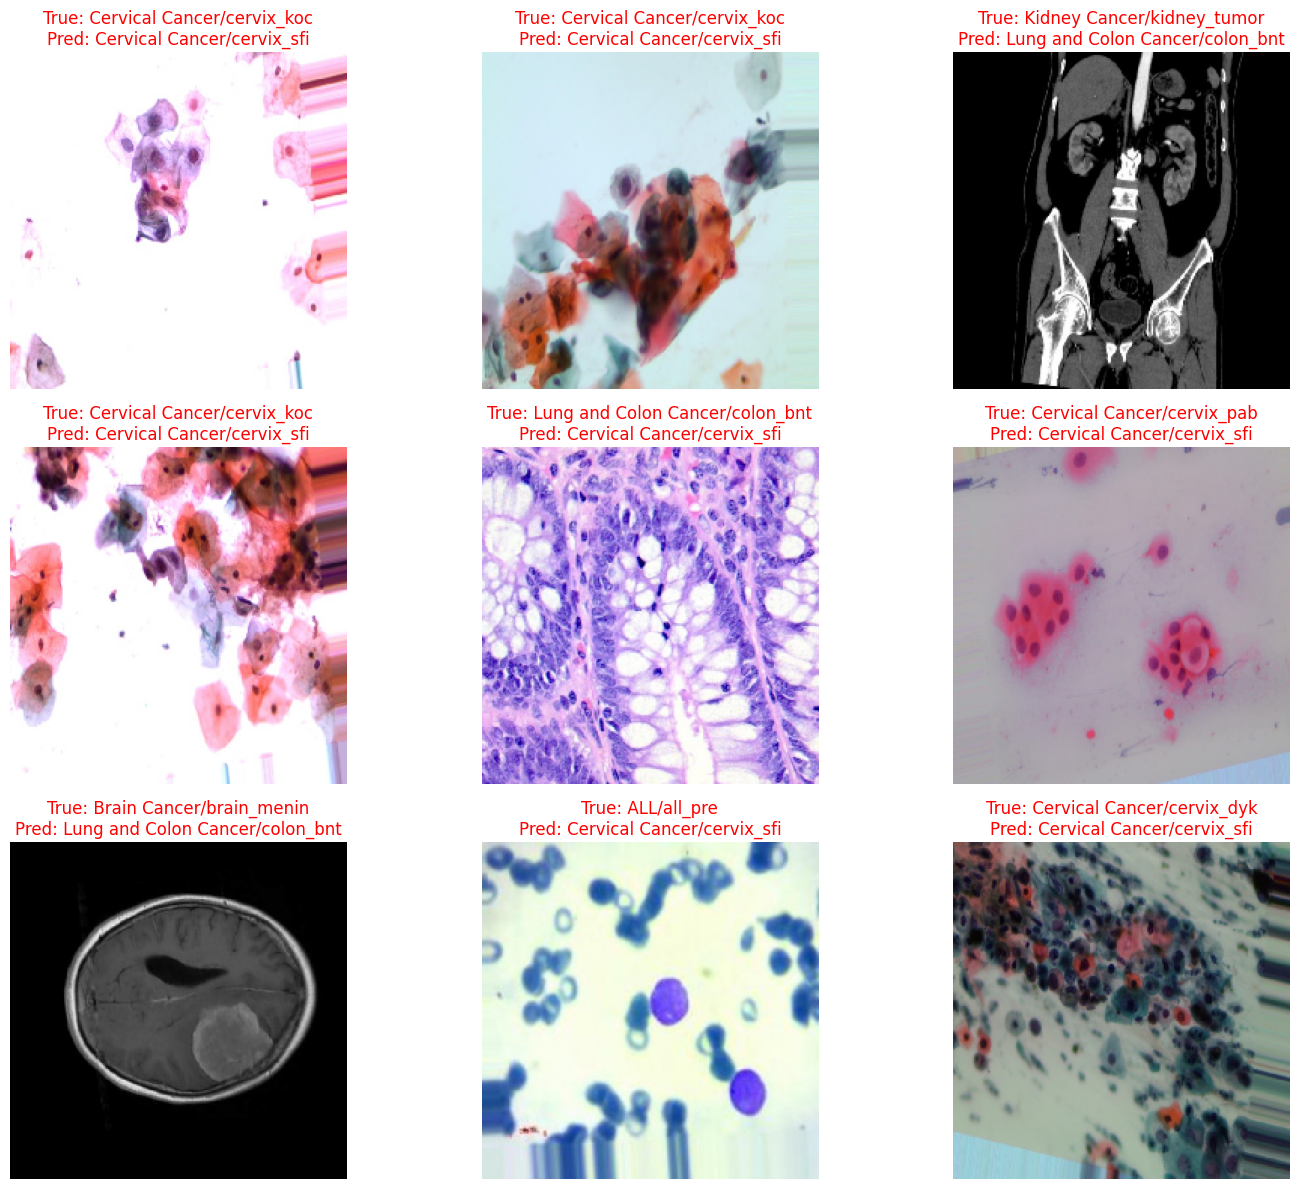

In [5]:
# 3. Confusion Matrix Visualization
plt.figure(figsize=(25, 20))
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 4. Training History Visualization (if history exists)
try:
    # Plot accuracy curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy', fontsize=12)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot loss curves
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss', fontsize=12)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
except NameError:
    print("Training history not available in this notebook")

# 5. Misclassification Analysis
misclassified_idx = np.where(y_pred != y_true)[0]
sample_idx = np.random.choice(misclassified_idx, 9, replace=False)

plt.figure(figsize=(15, 12))
for i, idx in enumerate(sample_idx):
    img_path = test_df.iloc[idx]['filepath']
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    true_class = class_names[y_true[idx]]
    pred_class = class_names[y_pred[idx]]
    plt.title(f'True: {true_class}\nPred: {pred_class}', color='red')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# 6. Fine-Tuning Suggestions (Optional)
print("\nFine-Tuning Recommendations:")
if test_acc < 0.97:
    print("Consider fine-tuning with these steps:")
    print("""
    # Unfreeze base layers
    model.trainable = True
    
    # Recompile with lower learning rate
    model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Train with early stopping
    fine_tune_epochs = 10
    history_fine = model.fit(
        train_gen,
        epochs=fine_tune_epochs,
        validation_data=valid_gen,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
    )
    """)
else:
    print("Model performance is already excellent (accuracy >97%). Fine-tuning may not be necessary.")


Fine-Tuning Recommendations:
Consider fine-tuning with these steps:

    # Unfreeze base layers
    model.trainable = True
    
    # Recompile with lower learning rate
    model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Train with early stopping
    fine_tune_epochs = 10
    history_fine = model.fit(
        train_gen,
        epochs=fine_tune_epochs,
        validation_data=valid_gen,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
    )
    


In [7]:
# First ensure all required imports are present
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adamax

# 1. Unfreeze base model layers
# Access the EfficientNetB0 base model from your Sequential model
base_model = model.layers[0]
base_model.trainable = True  # Unfreeze all layers

# 2. Recompile with lower learning rate
model.compile(
    optimizer=Adamax(learning_rate=1e-5),  # Reduced learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
# 3. Verify model structure
model.summary()

# 4. Create data generators (ensure they match original parameters)
# Training generator with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation generator (no augmentation)
valid_datagen = ImageDataGenerator()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,216,893 (16.09 MB)

 Trainable params: 4,174,870 (15.93 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [9]:
# Regenerate generators with correct paths
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepath',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

# 5. Implement fine-tuning with early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history_fine = model.fit(
    train_gen,
    epochs=10,
    validation_data=valid_gen,
    callbacks=[early_stop],
    verbose=1
)

# 6. Post fine-tuning evaluation
# Re-evaluate on test set
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f'\nPost-Fine-Tuning Test Accuracy: {test_acc * 100:.2f}%')

# Generate updated classification report
test_gen.reset()
y_pred_fine = model.predict(test_gen).argmax(axis=1)
print('\nUpdated Classification Report:')
print(classification_report(y_true, y_pred_fine, target_names=class_names, digits=4))

Found 91001 validated image filenames belonging to 26 classes.
Found 19500 validated image filenames belonging to 26 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1422/1422 ━━━━━━━━━━━━━━━━━━━━ 2168s 1s/step - accuracy: 0.9941 - loss: 0.0173 - val_accuracy: 0.9958 - val_loss: 0.0132
Epoch 2/10
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 1289s 902ms/step - accuracy: 0.9939 - loss: 0.0167 - val_accuracy: 0.9959 - val_loss: 0.0121
Epoch 3/10
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 1302s 912ms/step - accuracy: 0.9947 - loss: 0.0144 - val_accuracy: 0.9961 - val_loss: 0.0120
Epoch 4/10
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 1316s 921ms/step - accuracy: 0.9945 - loss: 0.0158 - val_accuracy: 0.9959 - val_loss: 0.0116
Epoch 5/10
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 1299s 910ms/step - accuracy: 0.9953 - loss: 0.0158 - val_accuracy: 0.9959 - val_loss: 0.0111
Epoch 6/10
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 1291s 904ms/step - accuracy: 0.9955 - loss: 0.0141 - val_accuracy: 0.9959 - val_loss: 0.0109
Epoch 7/10
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 1293s 905ms/step - accuracy: 0.9955 - loss: 0.0134 - val_accuracy: 0.9961 - val_loss: 0.0106
Epoch 8/10
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 1297s 908ms/step - accuracy

In [10]:
# Save architecture, weights, and optimizer state
model.save('/kaggle/working/fine_tuned_cancer_model.keras')  # .keras format
import json

# Save class-label mapping
class_indices = train_gen.class_indices
with open('/kaggle/working/class_indices.json', 'w') as f:
    json.dump(class_indices, f)

# Save fine-tuning history for analysis
import pickle

with open('/kaggle/working/fine_tune_history.pkl', 'wb') as f:
    pickle.dump(history_fine.history, f)

305/305 ━━━━━━━━━━━━━━━━━━━━ 74s 243ms/step


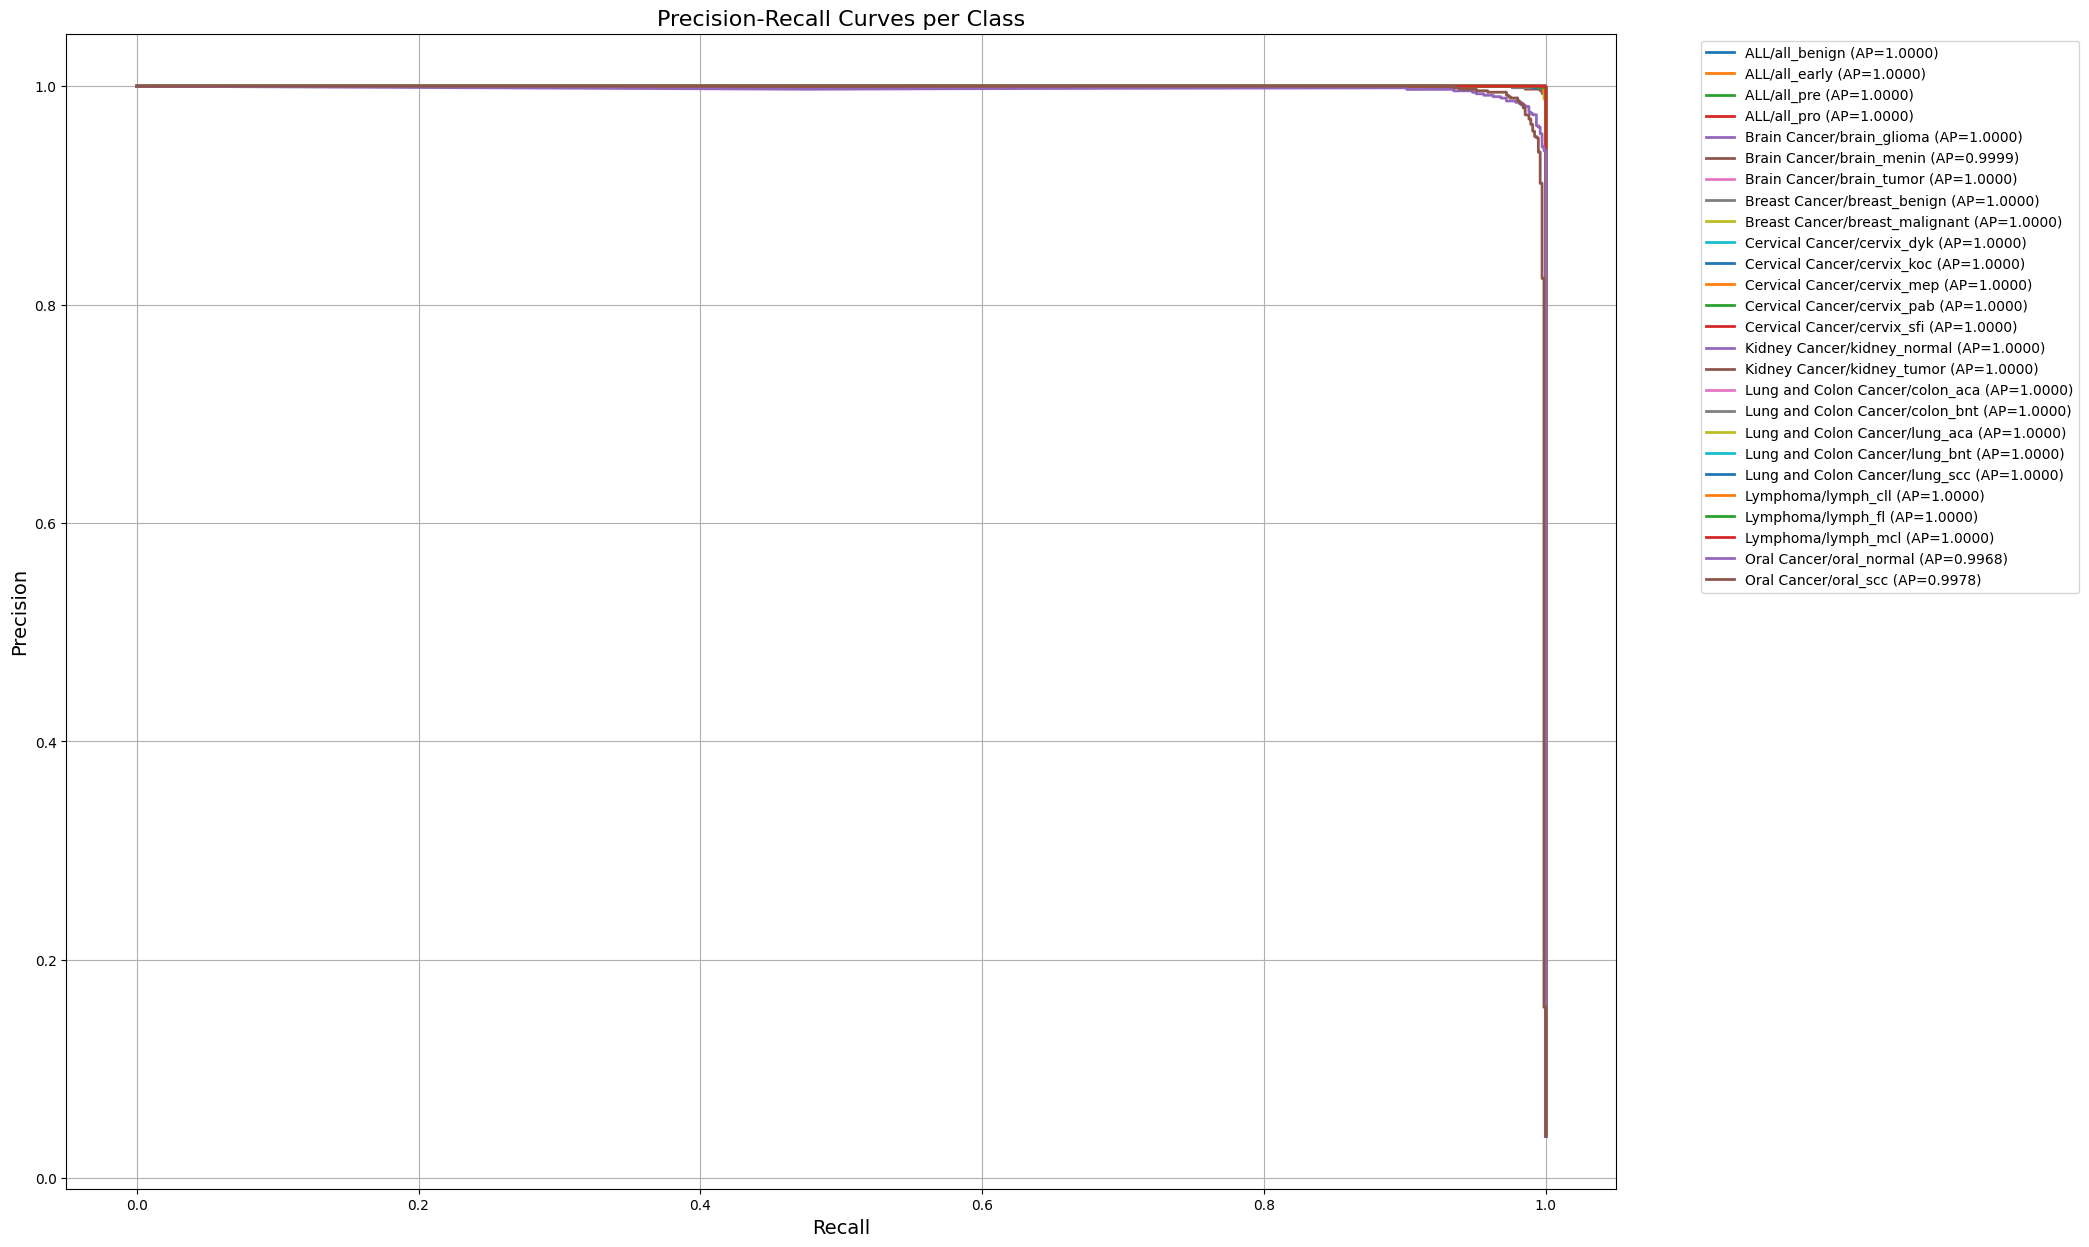

In [11]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

# Get predicted probabilities
y_probs = model.predict(test_gen)

# Binarize labels
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))

# Plot PR curves for each class
plt.figure(figsize=(20, 15))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
    avg_precision = average_precision_score(y_true_bin[:, i], y_probs[:, i])
    
    plt.plot(recall, precision, lw=2,
             label=f'{class_names[i]} (AP={avg_precision:.4f})')

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curves per Class', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

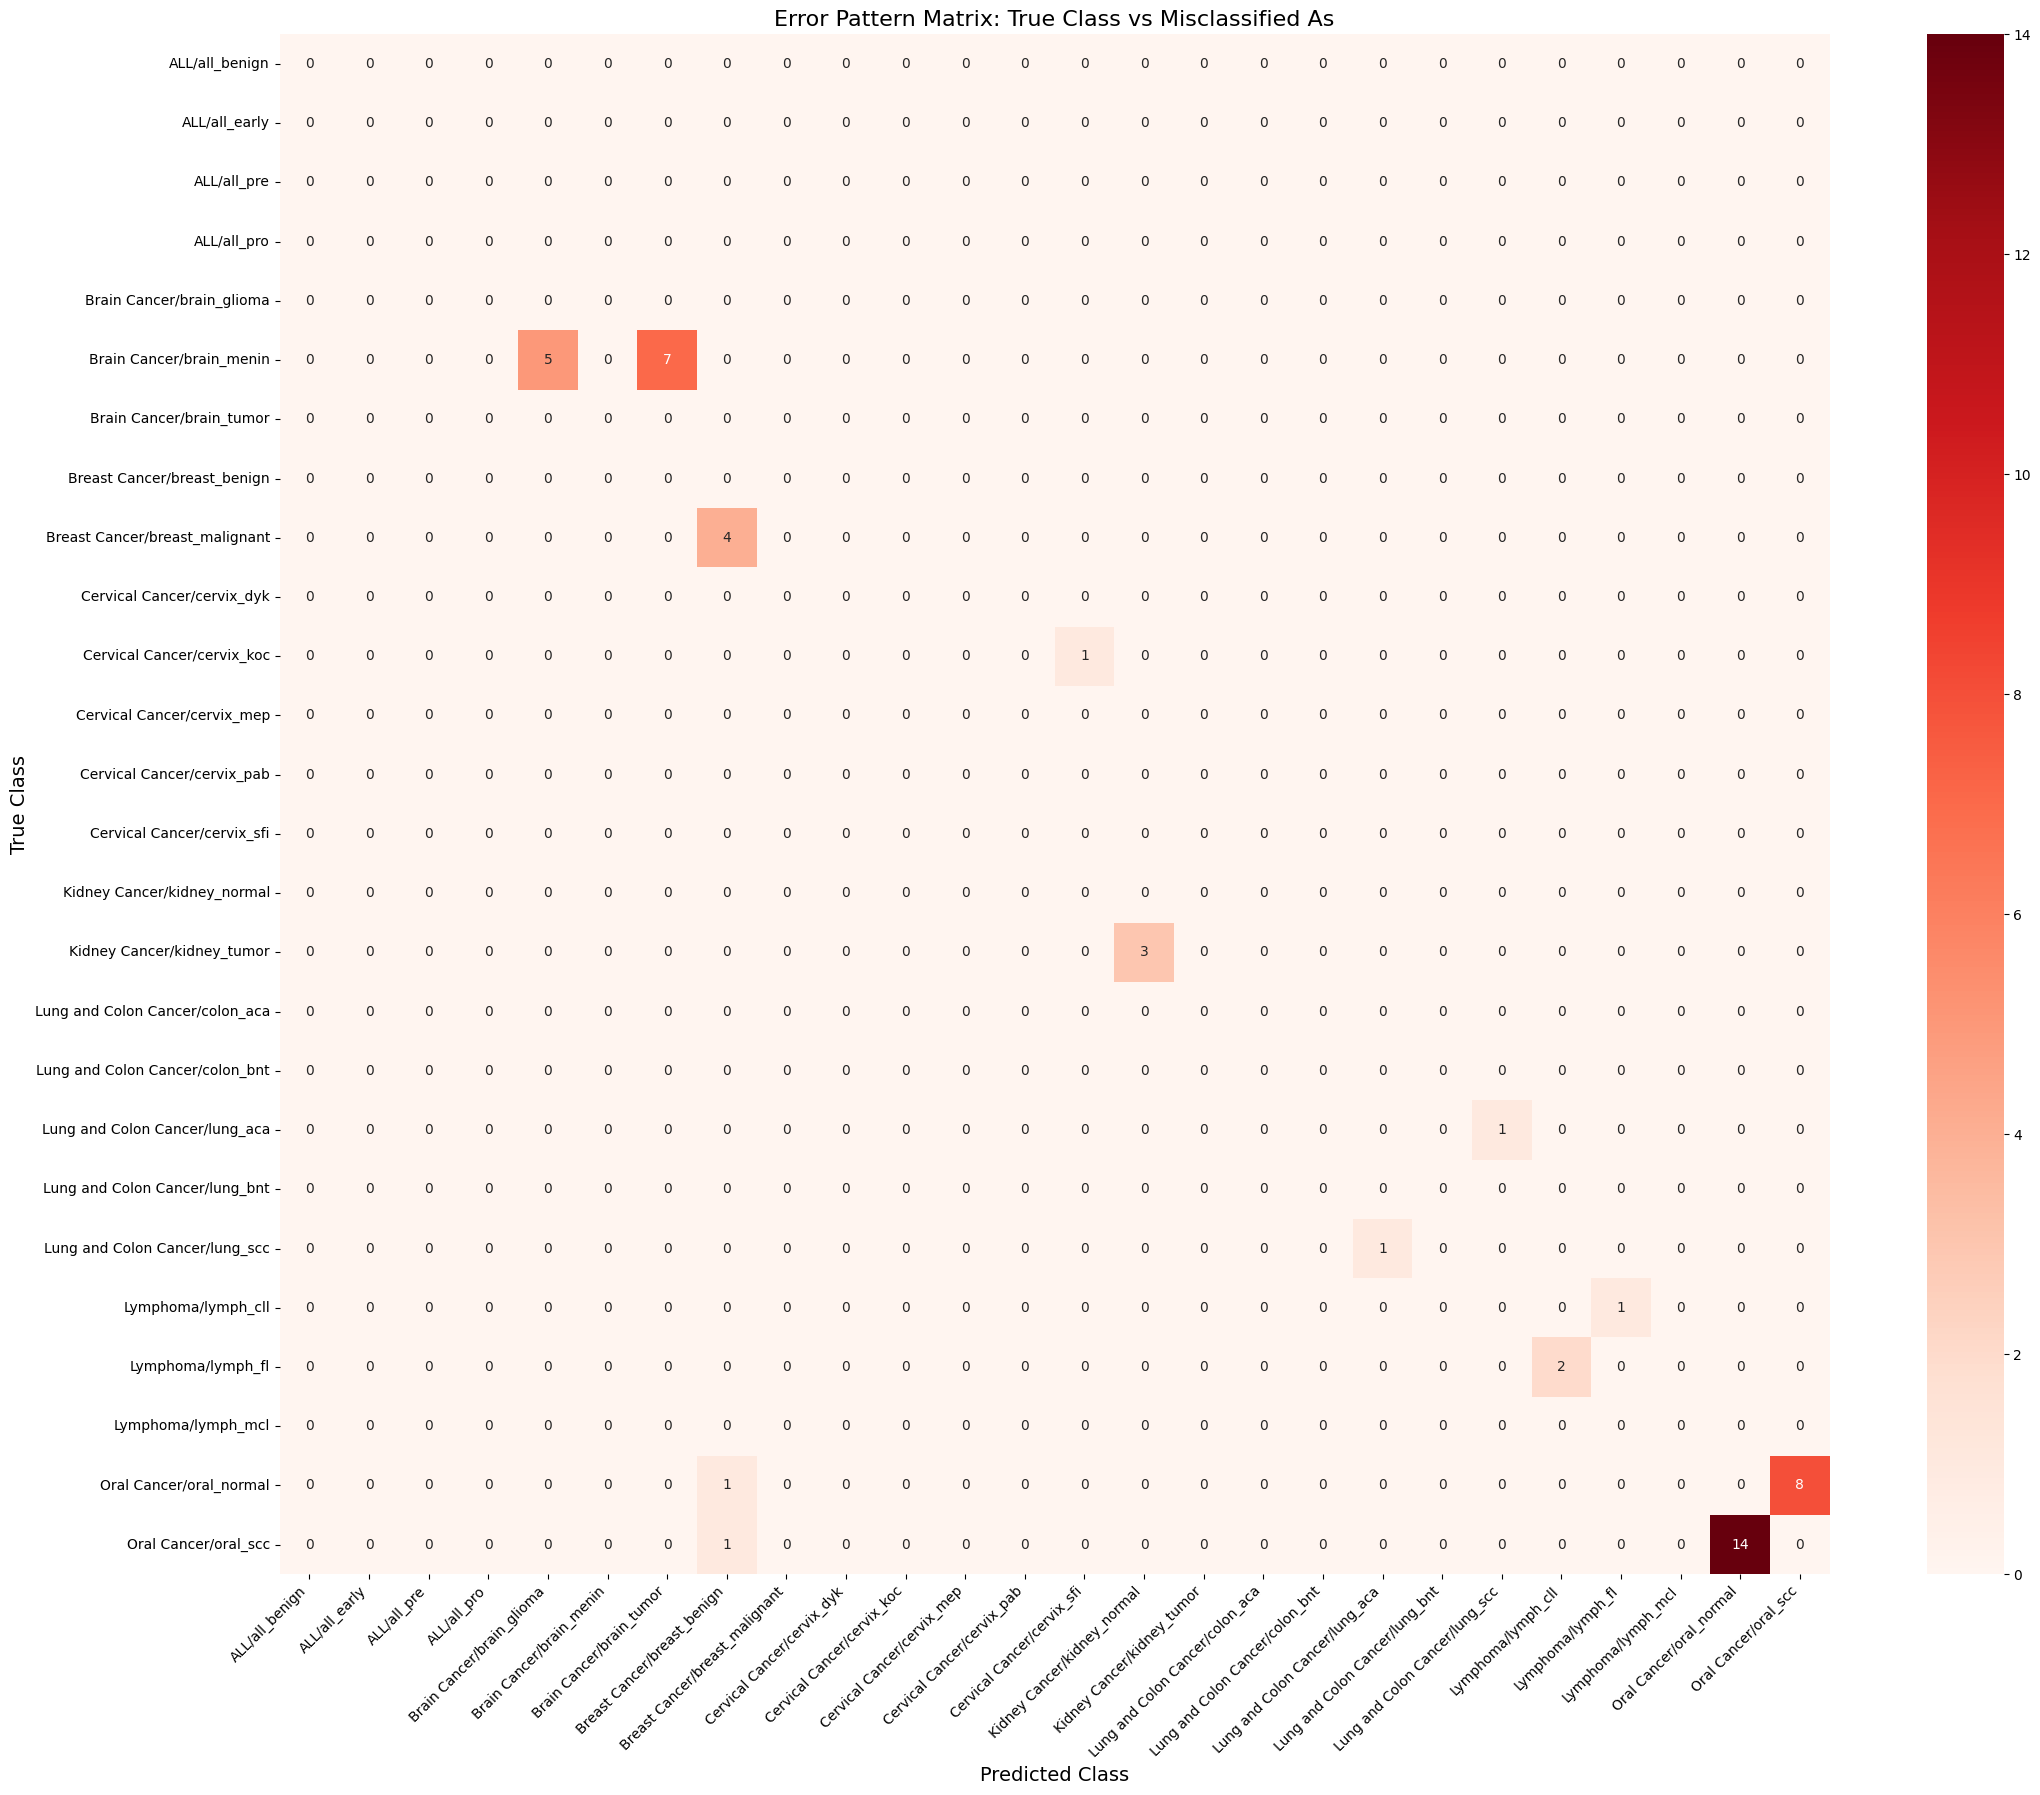

In [12]:
# Create error type matrix
error_matrix = np.zeros((len(class_names), len(class_names)))

for true, pred in zip(y_true, y_pred_fine):
    if true != pred:
        error_matrix[true, pred] += 1

plt.figure(figsize=(25, 20))
sns.heatmap(error_matrix, annot=True, fmt='.0f', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Error Pattern Matrix: True Class vs Misclassified As', fontsize=16)
plt.xlabel('Predicted Class', fontsize=14)
plt.ylabel('True Class', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

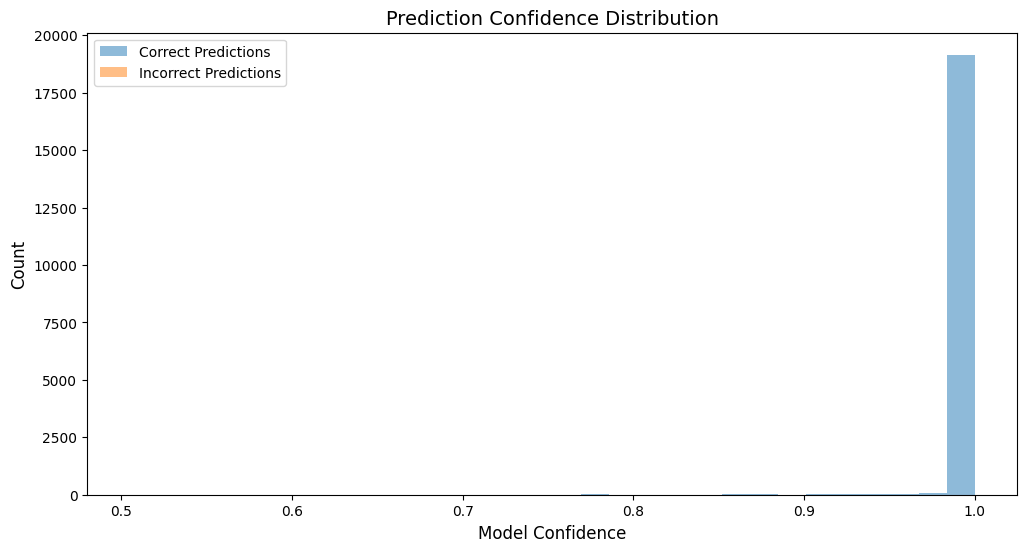

In [13]:
# Get confidence levels for correct vs incorrect predictions
correct_conf = []
incorrect_conf = []

for i in range(len(y_true)):
    prob = np.max(y_probs[i])
    if y_pred_fine[i] == y_true[i]:
        correct_conf.append(prob)
    else:
        incorrect_conf.append(prob)

plt.figure(figsize=(12, 6))
plt.hist(correct_conf, bins=30, alpha=0.5, label='Correct Predictions')
plt.hist(incorrect_conf, bins=30, alpha=0.5, label='Incorrect Predictions')
plt.title('Prediction Confidence Distribution', fontsize=14)
plt.xlabel('Model Confidence', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
plt.show()

In [14]:
# Focus on Oral Cancer classes
oral_classes = [class_names.index(c) for c in class_names if 'Oral Cancer' in c]

plt.figure(figsize=(20, 10))
plot_position = 1  # Initialize subplot position

for i, class_idx in enumerate(oral_classes):
    # Get misclassified samples for this class
    mask = (y_true == class_idx) & (y_pred_fine != class_idx)
    misclassified_samples = test_df[mask]
    
    # Skip if no misclassifications
    if len(misclassified_samples) == 0:
        print(f"No misclassifications found for {class_names[class_idx]}")
        continue
        
    # Sample up to 5 cases (or fewer if not available)
    sample_size = min(5, len(misclassified_samples))
    sampled_cases = misclassified_samples.sample(sample_size, random_state=42)
    
    for j, (idx, row) in enumerate(sampled_cases.iterrows()):
        plt.subplot(len(oral_classes), 5, plot_position)
        img = tf.keras.preprocessing.image.load_img(row['filepath'], target_size=img_size)
        plt.imshow(img)
        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred_fine[idx]]
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=8, color='red')
        plt.axis('off')
        plot_position += 1  # Increment position counter

# Remove empty subplots if any
total_plots = len(oral_classes) * 5
while plot_position <= total_plots:
    plt.delaxes(plt.subplot(len(oral_classes), 5, plot_position))
    plot_position += 1

plt.tight_layout()
plt.show()

No misclassifications found for Oral Cancer/oral_normal
No misclassifications found for Oral Cancer/oral_scc


<Figure size 2000x1000 with 0 Axes>

In [15]:
# Get the actual EfficientNetB0 base model from your Sequential model
base_model = model.layers[0]

# Find the real last convolutional layer name in EfficientNetB0
# This will vary based on exact model version - verify via:
base_model.summary()  # Look for last Conv2D layer

# For most EfficientNetB0 implementations:
last_conv_layer_name = "top_conv"  # Common name for final conv layer

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_4           │ (None, 224, 224, 3)    │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ normalization_4[0][0]  │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 32)       │            288 │ block1a_se_reduce[0][… │
│ (Conv2D)             

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

Last 5 layers of base model:
block7a_project_conv (Conv2D)
block7a_project_bn (BatchNormalization)
top_conv (Conv2D)
top_bn (BatchNormalization)
top_activation (Activation)


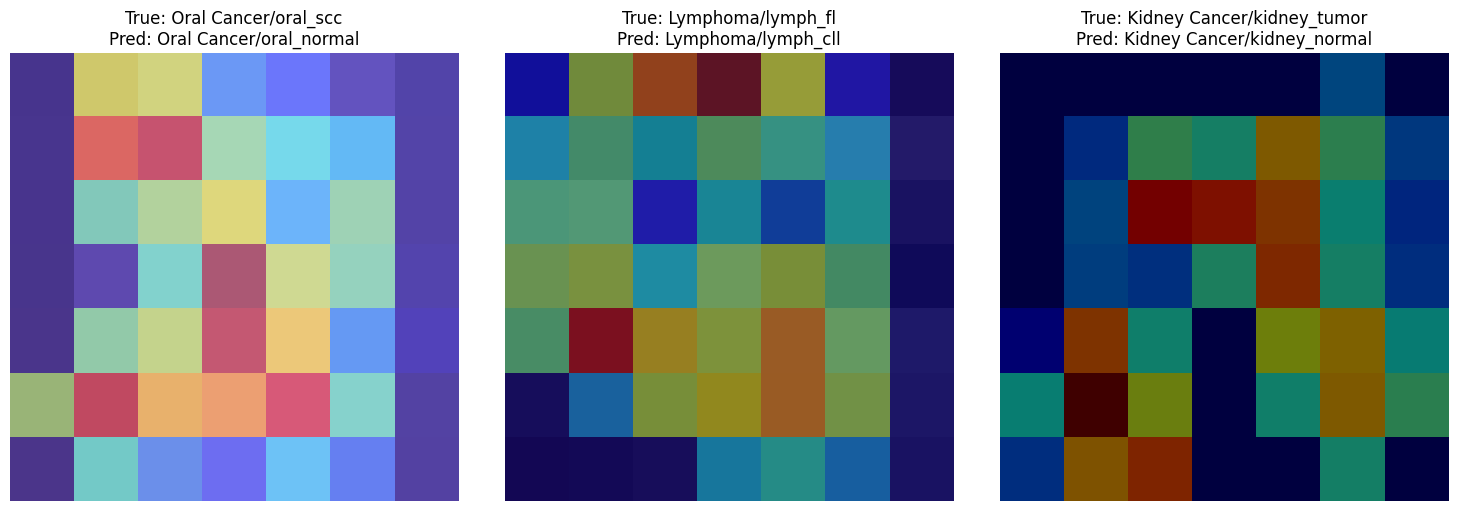

In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Get the actual EfficientNetB0 base model from your Sequential model
base_model = model.layers[0]

# Confirm the last convolutional layer
print("Last 5 layers of base model:")
for layer in base_model.layers[-5:]:
    print(f"{layer.name} ({layer.__class__.__name__})")

last_conv_layer_name = "top_conv"

# Grad-CAM Function
def make_gradcam_heatmap(img_array, base_model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        inputs=base_model.input,
        outputs=[
            base_model.get_layer(name=last_conv_layer_name).output,
            base_model.output
        ]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = tf.gather(predictions[0], pred_index)  # ✅ fixed here

    # Compute gradients
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight conv outputs
    heatmap = conv_outputs[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# Get misclassified indices
misclassified_indices = np.where(y_pred_fine != y_true)[0][:3]

# Plot
plt.figure(figsize=(15, 5))
for i, idx in enumerate(misclassified_indices):
    img_path = test_df.iloc[idx]['filepath']
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

    heatmap = make_gradcam_heatmap(img_array, base_model, last_conv_layer_name)

    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred_fine[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
